In [2]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
import cv2
import xarray as xr
mpl.rcParams.update({'font.size':10})
from matplotlib.backends.backend_pdf import PdfPages

from fmEphys.utils.path import find
from fmEphys.utils.auxiliary import flatten_series


DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [20]:
%matplotlib inline

In [2]:
def to_color(r,g,b):
    return (r/255, g/255, b/255)

# load data

In [3]:
figpath = '/home/niell_lab/Desktop/revision_figs_122922/'
hffm = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/hffm_062022_gt.pickle')
ltdk = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/ltdk_062022.pickle')

In [4]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
colors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}
psth_bins = np.arange(-1,1.001,1/1000)

# set up some plotting functions

In [5]:
def drop_nan_along(x, axis=1):
    # axis=1 will drop along columns (i.e. any rows with NaNs will be dropped)
    x = x[~np.isnan(x).any(axis=axis)]
    return x

In [6]:
def jitter_ax(center, size):
    return np.ones(size)+np.random.uniform(center-0.2, center+0.2, size)

In [7]:
def plot_cprop_scatter(panel, data, prop_name, use_median=False):
    for c, cluster in enumerate(['early','late','biphasic','negative']):
        cluster_data = data[prop_name][data['gazecluster']==cluster]
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(cluster_data,0))
        panel.plot(x_jitter, cluster_data, '.', color=cat_cmap[cluster], markersize=2)
        if use_median:
            hline = np.nanmedian(cluster_data)
        elif not use_median:
            hline = np.nanmean(cluster_data)
        panel.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
        err = np.std(cluster_data) / np.sqrt(np.size(cluster_data))
        panel.vlines(c, hline-err, hline+err, color='k', linewidth=2)
        panel.set_xticks(range(4), ['early','late','biphasic','negative'])

In [8]:
def plot_tempseq(panel, tseq, return_img=False, freev=None):
    panel.set_xlabel('time (msec)')
    panel.set_ylim([np.size(tseq,0),0])
    vmin = -0.75; vmax = 0.75
    if freev is not None:
        vmin = -freev
        vmax = freev
    img = panel.imshow(tseq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    panel.set_xlim([800,1400])
    panel.set_xticks(np.linspace(800,1400,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(1000, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    if return_img:
        return img

In [17]:
[col for col in hffm.columns if 'saccT' in col]

['FmLt_gazeshift_left_saccTimes_dHead',
 'FmLt_gazeshift_right_saccTimes_dHead',
 'FmLt_comp_left_saccTimes_dHead',
 'FmLt_comp_right_saccTimes_dHead',
 'FmLt_gazeshift_left_saccTimes_dHead1',
 'FmLt_gazeshift_right_saccTimes_dHead1',
 'FmLt_comp_left_saccTimes_dHead1',
 'FmLt_comp_right_saccTimes_dHead1']

In [14]:
for ind, row in hffm.iterrows():
    
    saccT = row['FmLt_gazeshift_left_saccTimes_dHead1'].copy()
    
    saccT

0      [0.2843270000012126, 1.6037250000008498, 1.851...
1      [0.2843270000012126, 1.6037250000008498, 1.851...
2      [0.2843270000012126, 1.6037250000008498, 1.851...
3      [0.2843270000012126, 1.6037250000008498, 1.851...
4      [0.2843270000012126, 1.6037250000008498, 1.851...
                             ...                        
711    [9.179764000000432, 9.195764000003692, 10.7477...
712    [9.179764000000432, 9.195764000003692, 10.7477...
713    [9.179764000000432, 9.195764000003692, 10.7477...
714    [9.179764000000432, 9.195764000003692, 10.7477...
715    [9.179764000000432, 9.195764000003692, 10.7477...
Name: FmLt_gazeshift_left_saccTimes_dHead, Length: 716, dtype: object

In [12]:
plt.scatter(hffm.loc[0,''], hffm.loc[0]

array([66.15516662, 38.64384415, 41.52417184, ...,         nan,
               nan,         nan])

In [141]:
row = hffm.iloc[215].copy()

In [142]:
def interp_nans(y):
    nans = np.isnan(y)
    x = lambda z: z.nonzero()[0]
    
    y[nans] = np.interp(x(nans), x(~nans), y[~nans])
    
    return y

In [172]:
# comp saccade times
saccTcomp = []
saccTcomp.extend(row['FmLt_comp_left_saccTimes_dHead1'].copy())
saccTcomp.extend(row['FmLt_comp_right_saccTimes_dHead1'].copy())

In [174]:
compspeeds_arr = np.zeros([len(saccTcomp), 4, 21])
    # spike rate, dEye speed, dGaze speed

for i, t in enumerate(saccTcomp):
    saccInd = np.nanargmin(np.abs(eyeT-t))
    indRange = np.arange(saccInd-10, saccInd+11)
    # win_eye_speed = dEye[saccInd-3:saccInd+3].copy()
    # saccSpeed = np.abs(np.nanmax(win_eye_speed) - np.nanmin(win_eye_speed))
    
    compspeeds_arr[i,0,:] = binned_rate[indRange]
    
    compspeeds_arr[i,1,:] = dEye[indRange]
    
    compspeeds_arr[i,2,:] = dHead[indRange]
    
    compspeeds_arr[i,3,:] = dGaze[indRange]
    

In [143]:
# gaze saccade times
saccT = []
saccT.extend(row['FmLt_gazeshift_left_saccTimes_dHead1'].copy())
saccT.extend(row['FmLt_gazeshift_right_saccTimes_dHead1'].copy())

eyeT = interp_nans(row['FmLt_eyeT'].copy())
dEye = row['FmLt_dEye_dps'].copy()
dHead = row['FmLt_dHead'].copy()
dGaze = row['FmLt_dGaze'].copy()
spikeT = row['FmLt_spikeT'].copy()

# spike binning
# dT = 1/60
# modelT = np.arange(0, np.nanmax(eyeT), dT)
# bins = np.append(modelT, modelT[-1]+dT)
binned_rate, _ = np.histogram(spikeT, eyeT)
# binned_rate = binned_rate / dT

In [144]:
speeds_arr = np.zeros([len(saccT), 4, 21])
    # spike rate, dEye speed, dGaze speed

for i, t in enumerate(saccT):
    saccInd = np.nanargmin(np.abs(eyeT-t))
    indRange = np.arange(saccInd-10, saccInd+11)
    # win_eye_speed = dEye[saccInd-3:saccInd+3].copy()
    # saccSpeed = np.abs(np.nanmax(win_eye_speed) - np.nanmin(win_eye_speed))
    
    speeds_arr[i,0,:] = binned_rate[indRange]
    
    speeds_arr[i,1,:] = dEye[indRange]
    
    speeds_arr[i,2,:] = dHead[indRange]
    
    speeds_arr[i,3,:] = dGaze[indRange]
    

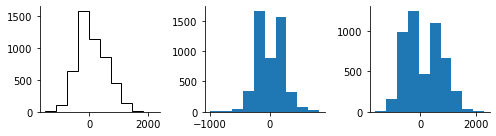

In [170]:
fig, [ax0,ax1,ax2] = plt.subplots(1,3,figsize=(7,2))

ax0.hist(speeds_arr[:,1,10], histtype='step', color='k')

ax1.hist(speeds_arr[:,2,10])

ax2.hist(speeds_arr[:,3,10])


fig.tight_layout()

In [176]:
sp_before = np.sum(speeds_arr[:,0,:9], axis=1)
sp_after = np.sum(speeds_arr[:,0,10:], axis=1)

In [1]:
plt.bar(speeds_arr[:,0,10], speeds_arr[:,1,10])

NameError: name 'plt' is not defined

(array([   9.,  104.,  638., 1569., 1145.,  853.,  444.,  142.,   14.,
           3.]),
 array([-1498.58020098, -1128.39589976,  -758.21159855,  -388.02729734,
          -17.84299612,   352.34130509,   722.52560631,  1092.70990752,
         1462.89420874,  1833.07850995,  2203.26281116]),
 <BarContainer object of 10 artists>)

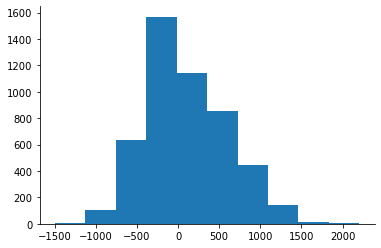

In [161]:
plt.hist(speeds_arr[:,1,10])

In [157]:
def psth_modind(psth):

    psth = psth.astype(float)
    
    pre = np.nanmean(psth[0:9])
    post = np.nanmean(psth[10:])
    
    # diff / sum
    
    mod = np.max(np.abs(use[10:]))
    
    return mod

In [ ]:
for i in range(np.size(speeds_arr,0)):
    psth_modind()
    

In [151]:
saccInd = 0
dict(zip(range(0,21),np.arange(saccInd-10, saccInd+11)))

{0: -10,
 1: -9,
 2: -8,
 3: -7,
 4: -6,
 5: -5,
 6: -4,
 7: -3,
 8: -2,
 9: -1,
 10: 0,
 11: 1,
 12: 2,
 13: 3,
 14: 4,
 15: 5,
 16: 6,
 17: 7,
 18: 8,
 19: 9,
 20: 10}

(4921,)

In [ ]:
np.nanmean(speeds_arr[:,3,0:10],axis=1).shape

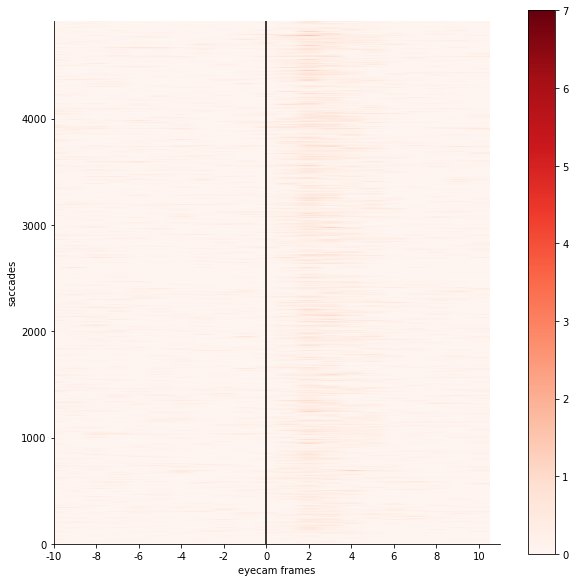

In [150]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
colorbar_obj = ax.imshow(speeds_arr[:,0,:], aspect=0.005, cmap='Reds')
ax.set_xticks(np.arange(0,21,2), labels=np.arange(-10,11,2))
ax.set_ylabel('saccades')
ax.set_xlabel('eyecam frames')
ax.vlines(10, 0, np.size(speeds_arr,0), color='k')
ax.set_ylim([0, np.size(speeds_arr,0)])
ax.set_xlim([0, 21])

fig.colorbar(colorbar_obj)

In [124]:
np.arange(-10,11,2)

array([-10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10])

In [125]:
np.arange(0,21,2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [114]:
speeds_arr[:,0,:].shape

(2692, 21)